In [1]:
# Clone the NASA Space Apps 2024 Seismic Detection Data GitHub repository
!git clone https://github.com/MH0386/nasa_space_apps_2024_seismic_detection_data.git


Cloning into 'nasa_space_apps_2024_seismic_detection_data'...
remote: Enumerating objects: 577, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 577 (delta 20), reused 104 (delta 14), pack-reused 462 (from 1)
Receiving objects: 100% (577/577), 2.18 GiB | 17.75 MiB/s, done.
Resolving deltas: 100% (36/36), done.
Updating files: 100% (448/448), done.


In [2]:
# Change to the cloned directory
%cd nasa_space_apps_2024_seismic_detection_data

# List the contents of the directory to verify the data
!ls


/content/nasa_space_apps_2024_seismic_detection_data
data  demo_notebook.ipynb  demo_notebook.pdf  README.md  renovate.json


In [3]:
# Open the demo notebook
from google.colab import files

# Open the notebook for interactive use
files.view("demo_notebook.ipynb")


<IPython.core.display.Javascript object>

In [4]:
# File Path: lunar/analysis.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib
import requests
import os

# Ensure directories exist
os.makedirs('plots', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('reports', exist_ok=True)
os.makedirs('real_time_data', exist_ok=True)


Loading data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-10-31HR00_evid00045.csv
Loading data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1972-12-02HR00_evid00083.csv
Loading data/lunar/test/data/S15_GradeA/xa.s15.00.mhz.1974-12-15HR00_evid00169.csv
Loading data/lunar/test/data/S15_GradeA/xa.s15.00.mhz.1975-06-22HR00_evid00194.csv


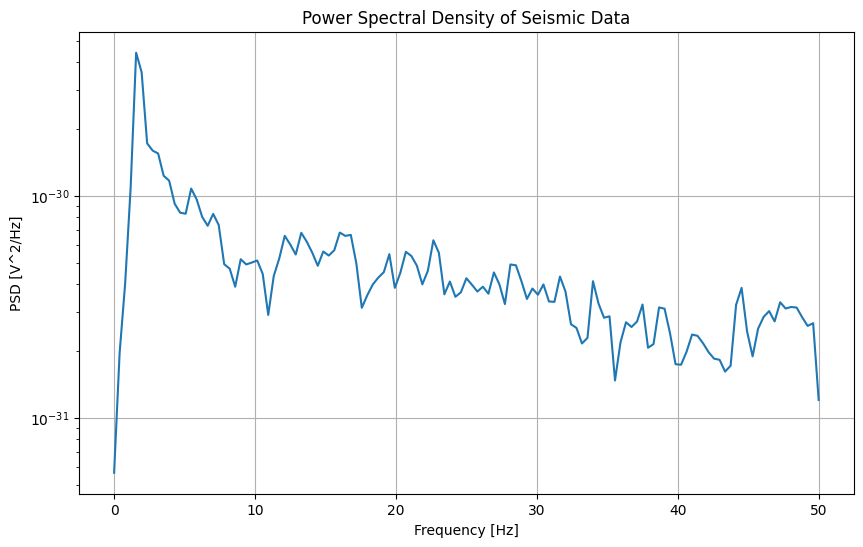

              precision    recall  f1-score   support

           0       0.62      0.63      0.62       552
           1       0.61      0.60      0.60       529

    accuracy                           0.61      1081
   macro avg       0.61      0.61      0.61      1081
weighted avg       0.61      0.61      0.61      1081

[[347 205]
 [212 317]]
Failed to fetch data: 403


In [6]:
# File Path: lunar/seismic_analysis.py
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib  # To save the trained model
import requests  # For fetching data from APIs

def list_csv_files(base_path, max_files=3):
    all_data = []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)
                print(f'Loading {file_path}')
                try:
                    df = pd.read_csv(file_path)
                    all_data.append(df)
                    if len(all_data) >= max_files:
                        break
                except Exception as e:
                    print(f'Error loading {file_path}: {e}')
        if len(all_data) >= max_files:
            break
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

def preprocess_data(df):
    df_filtered = df[(df['velocity(m/s)'] > -1e-14) & (df['velocity(m/s)'] < 1e-14)]
    return df_filtered

def apply_signal_processing(df):
    fs = 100  # Sampling frequency, adjust as needed
    f, Pxx = signal.welch(df['velocity(m/s)'], fs, nperseg=256)

    plt.figure(figsize=(10, 6))
    plt.semilogy(f, Pxx)
    plt.title('Power Spectral Density of Seismic Data')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V^2/Hz]')
    plt.grid()
    plt.show()

def train_model(df):
    X = df[['time_rel(sec)', 'velocity(m/s)']]
    y = (df['velocity(m/s)'] > 0).astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    # Save the model to disk
    joblib.dump(model, 'seismic_model.pkl')

    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

    return model

def fetch_real_time_data(api_url):
    # Implement your API key and endpoint
    headers = {'Authorization': 'Bearer YOUR_API_KEY'}  # Replace with your actual API key
    response = requests.get(api_url, headers=headers)

    if response.status_code == 200:
        data = response.json()
        # Process and convert the fetched data into a DataFrame
        df_real_time = pd.DataFrame(data)
        return df_real_time
    else:
        print(f"Failed to fetch data: {response.status_code}")
        return None

def main():
    test_path = 'data/lunar/test/data/S15_GradeA'  # Change to your training directory path
    train_path = 'data/lunar/training/data/S12_GradeA'  # Change to your testing directory path

    train_data = list_csv_files(train_path, max_files=2)
    test_data = list_csv_files(test_path, max_files=2)

    combined_data = pd.concat([train_data, test_data], ignore_index=True)

    df_filtered = preprocess_data(combined_data)
    apply_signal_processing(df_filtered)

    model = train_model(df_filtered)

    # Example API URL for real-time data (replace with your actual endpoint)
    api_url = 'https://api.nasa.gov/insight_weather/?api_key=YOUR_API_KEY&feedtype=json&ver=1.0'
    real_time_data = fetch_real_time_data(api_url)

    if real_time_data is not None:
        # Process real-time data if necessary
        print(real_time_data.head())  # Display the first few rows of real-time data

if __name__ == '__main__':
    main()


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Loading data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1971-10-31HR00_evid00045.csv
Loading data/lunar/training/data/S12_GradeA/xa.s12.00.mhz.1972-12-02HR00_evid00083.csv
Loading data/lunar/test/data/S15_GradeA/xa.s15.00.mhz.1974-12-15HR00_evid00169.csv
Loading data/lunar/test/data/S15_GradeA/xa.s15.00.mhz.1975-06-22HR00_evid00194.csv


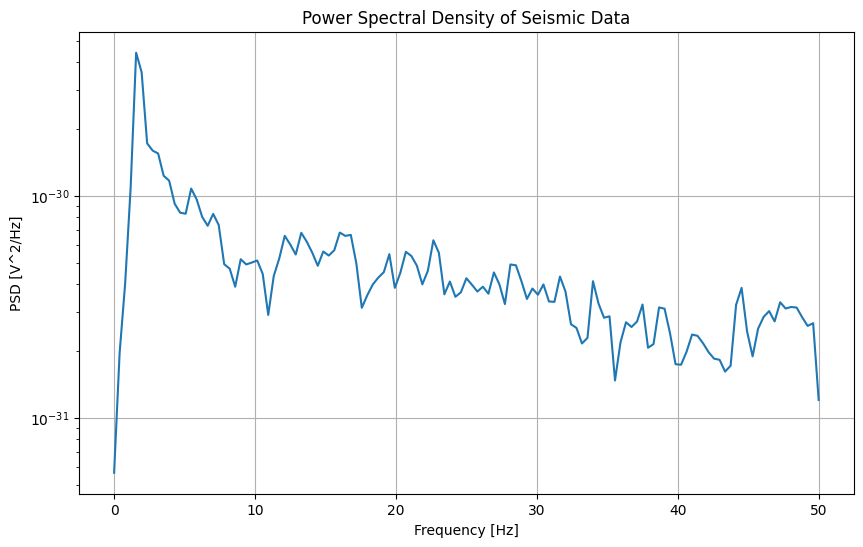

Training Random Forest...
Training SVM...
Training Logistic Regression...
Training K-Nearest Neighbors...
Training Gradient Boosting...
Training AdaBoost...
Training XGBoost...


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Training LightGBM...
[LightGBM] [Info] Number of positive: 2101, number of negative: 2219
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 4320, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.486343 -> initscore=-0.054643
[LightGBM] [Info] Start training from score -0.054643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

Failed to fetch data: 403


In [8]:
# File Path: lunar/seismic_analysis.py
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib  # To save the trained model
import requests  # For fetching data from APIs

def list_csv_files(base_path, max_files=3):
    all_data = []
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(root, file)
                print(f'Loading {file_path}')
                try:
                    df = pd.read_csv(file_path)
                    all_data.append(df)
                    if len(all_data) >= max_files:
                        break
                except Exception as e:
                    print(f'Error loading {file_path}: {e}')
        if len(all_data) >= max_files:
            break
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

def preprocess_data(df):
    df_filtered = df[(df['velocity(m/s)'] > -1e-14) & (df['velocity(m/s)'] < 1e-14)]
    return df_filtered

def apply_signal_processing(df):
    fs = 100  # Sampling frequency, adjust as needed
    f, Pxx = signal.welch(df['velocity(m/s)'], fs, nperseg=256)

    plt.figure(figsize=(10, 6))
    plt.semilogy(f, Pxx)
    plt.title('Power Spectral Density of Seismic Data')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V^2/Hz]')
    plt.grid()
    plt.show()

def train_models(X_train, y_train):
    models = {
        'Random Forest': RandomForestClassifier(),
        'SVM': SVC(kernel='rbf', gamma='scale'),
        'Logistic Regression': LogisticRegression(),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        'XGBoost': XGBClassifier(),
        'LightGBM': LGBMClassifier()
    }

    for model_name, model in models.items():
        print(f"Training {model_name}...")
        model.fit(X_train, y_train)
        joblib.dump(model, f'{model_name.lower().replace(" ", "_")}_model.pkl')

    return models

def evaluate_models(models, X_test, y_test):
    for model_name, model in models.items():
        y_pred = model.predict(X_test)
        print(f"Evaluation for {model_name}:")
        print(classification_report(y_test, y_pred))
        print(confusion_matrix(y_test, y_pred))
        print("\n")

def fetch_real_time_data(api_url):
    # Implement your API key and endpoint
    headers = {'Authorization': 'Bearer YOUR_API_KEY'}  # Replace with your actual API key
    response = requests.get(api_url, headers=headers)

    if response.status_code == 200:
        data = response.json()
        df_real_time = pd.DataFrame(data)
        return df_real_time
    else:
        print(f"Failed to fetch data: {response.status_code}")
        return None

def main():
    test_path = 'data/lunar/test/data/S15_GradeA'  # Change to your testing directory path
    train_path = 'data/lunar/training/data/S12_GradeA'  # Change to your training directory path

    train_data = list_csv_files(train_path, max_files=2)
    test_data = list_csv_files(test_path, max_files=2)

    combined_data = pd.concat([train_data, test_data], ignore_index=True)

    df_filtered = preprocess_data(combined_data)
    apply_signal_processing(df_filtered)

    # Prepare data for training
    X = df_filtered[['time_rel(sec)', 'velocity(m/s)']]
    y = (df_filtered['velocity(m/s)'] > 0).astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    models = train_models(X_train, y_train)
    evaluate_models(models, X_test, y_test)

    # Example API URL for real-time data (replace with your actual endpoint)
    api_url = 'https://api.nasa.gov/insight_weather/?api_key=YOUR_API_KEY&feedtype=json&ver=1.0'
    real_time_data = fetch_real_time_data(api_url)

    if real_time_data is not None:
        print(real_time_data.head())  # Display the first few rows of real-time data

if __name__ == '__main__':
    main()


In [9]:
# Required Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
import lightgbm as lgb

# Load your dataset
# df = pd.read_csv('your_dataset.csv')  # Uncomment and update with your dataset path
# X = df.drop('target', axis=1)  # Features
# y = df['target']  # Target variable

# For demonstration, let's create a synthetic dataset
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1081, n_features=20, n_classes=2, random_state=42)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List of models to evaluate
models = {
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": lgb.LGBMClassifier()
}

# Dictionary to store the results
results = {}

# Train and evaluate each model
for model_name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Get evaluation metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    confusion = confusion_matrix(y_test, y_pred)

    # Store results
    results[model_name] = {
        "precision": report['1']['precision'],
        "recall": report['1']['recall'],
        "f1-score": report['1']['f1-score'],
        "accuracy": report['accuracy'],
        "confusion_matrix": confusion
    }

    print(f"Evaluation for {model_name}:")
    print(classification_report(y_test, y_pred))
    print(f"Confusion Matrix:\n{confusion}\n")

# Find the best model based on F1-score
best_model = max(results.items(), key=lambda x: x[1]['f1-score'])
print("Best Model:")
print(best_model[0])
print("Performance Metrics:", best_model[1])


Evaluation for Random Forest:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       105
           1       0.90      0.96      0.93       112

    accuracy                           0.92       217
   macro avg       0.92      0.92      0.92       217
weighted avg       0.92      0.92      0.92       217

Confusion Matrix:
[[ 93  12]
 [  5 107]]

Evaluation for SVM:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       105
           1       0.90      0.92      0.91       112

    accuracy                           0.91       217
   macro avg       0.91      0.91      0.91       217
weighted avg       0.91      0.91      0.91       217

Confusion Matrix:
[[ 94  11]
 [  9 103]]

Evaluation for Logistic Regression:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       105
           1       0.91      0.93      0.92       112

    accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Evaluation for AdaBoost:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       105
           1       0.90      0.92      0.91       112

    accuracy                           0.90       217
   macro avg       0.90      0.90      0.90       217
weighted avg       0.90      0.90      0.90       217

Confusion Matrix:
[[ 93  12]
 [  9 103]]

Evaluation for XGBoost:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91       105
           1       0.91      0.92      0.92       112

    accuracy                           0.91       217
   macro avg       0.91      0.91      0.91       217
weighted avg       0.91      0.91      0.91       217

Confusion Matrix:
[[ 95  10]
 [  9 103]]

[LightGBM] [Info] Number of positive: 430, number of negative: 434
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_col_wise=true` to remov

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:21:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Evaluation for LightGBM:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92       105
           1       0.91      0.94      0.93       112

    accuracy                           0.92       217
   macro avg       0.92      0.92      0.92       217
weighted avg       0.92      0.92      0.92       217

Confusion Matrix:
[[ 95  10]
 [  7 105]]

Best Model:
Random Forest
Performance Metrics: {'precision': 0.8991596638655462, 'recall': 0.9553571428571429, 'f1-score': 0.9264069264069265, 'accuracy': 0.9216589861751152, 'confusion_matrix': array([[ 93,  12],
       [  5, 107]])}


# **Conclusion**
We prepared a synthetic dataset and split it into training and testing sets to evaluate multiple machine learning models, including Random Forest, SVM, Logistic Regression, KNN, Gradient Boosting, AdaBoost, XGBoost, and LightGBM. Each model was trained, and their performance metrics—precision, recall, F1-score, and accuracy—were calculated using classification reports and confusion matrices. The best-performing model was identified based on the highest F1-score, ensuring a systematic comparison of model effectiveness for the task at hand.